In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np


%matplotlib inline
%load_ext autoreload
%autoreload 2

###  Loading and pre-processing the data

In [2]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_train_data.pkl") 
train_data = train_data.dropna()

In [3]:
x_data = train_data.iloc[:,:15]
y_data = train_data.iloc[:,15:]

In [4]:
# choosing one input dimension and one output dimension as random
input_dim = np.random.permutation(list(x_data.columns))
output_dim = np.random.permutation(list(y_data.columns))

In [5]:
print(f"Input dimension to use: {input_dim[0]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: x
Input dimension to use: efitem_gb_div_efetem_gb


In [6]:
x_train_data = x_data[f'{input_dim[0]}']
y_train_data = y_data[f'{output_dim[0]}']

assert x_train_data.shape[0] == y_train_data.shape[0]

In [7]:
n = 100
idx = np.random.permutation(n)

In [8]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_min, x_max = x_train_data.min(), x_train_data.max()

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train_data, y_train_data, likelihood)

In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 250


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train_data)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train_data)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/250 - Loss: 1.089   lengthscale: 0.693   noise: 0.693
Iter 2/250 - Loss: 1.074   lengthscale: 0.744   noise: 0.644
Iter 3/250 - Loss: 1.061   lengthscale: 0.798   noise: 0.598
Iter 4/250 - Loss: 1.050   lengthscale: 0.853   noise: 0.555
Iter 5/250 - Loss: 1.041   lengthscale: 0.910   noise: 0.515
Iter 6/250 - Loss: 1.035   lengthscale: 0.968   noise: 0.479
Iter 7/250 - Loss: 1.031   lengthscale: 1.027   noise: 0.447
Iter 8/250 - Loss: 1.030   lengthscale: 1.086   noise: 0.420
Iter 9/250 - Loss: 1.030   lengthscale: 1.145   noise: 0.398
Iter 10/250 - Loss: 1.031   lengthscale: 1.203   noise: 0.383
Iter 11/250 - Loss: 1.032   lengthscale: 1.260   noise: 0.374
Iter 12/250 - Loss: 1.032   lengthscale: 1.315   noise: 0.371
Iter 13/250 - Loss: 1.031   lengthscale: 1.368   noise: 0.373
Iter 14/250 - Loss: 1.030   lengthscale: 1.418   noise: 0.378
Iter 15/250 - Loss: 1.028   lengthscale: 1.464   noise: 0.387
Iter 16/250 - Loss: 1.026   lengthscale: 1.508   noise: 0.397
Iter 17/250 - Los

Iter 175/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 176/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 177/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 178/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 179/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 180/250 - Loss: 1.003   lengthscale: 1.930   noise: 0.436
Iter 181/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 182/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 183/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 184/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 185/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 186/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 187/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 188/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 189/250 - Loss: 1.003   lengthscale: 1.929   noise: 0.436
Iter 190/250 - Loss: 1.003   lengthscale: 1.929   noise

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(x_min, x_max , 51, dtype = torch.double)
    observed_pred = likelihood(model(test_x))

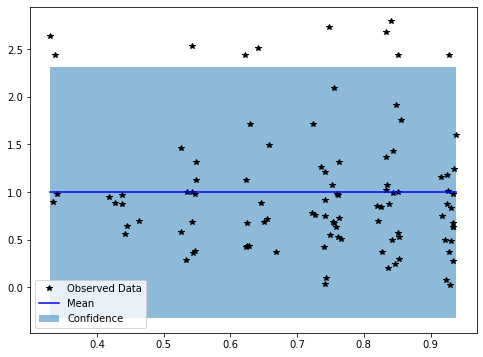

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train_data.numpy(), y_train_data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])